In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment = None

In [25]:
data = [
    [5, 0.025, 2],
    [5, 0.050, 3],
    [5, 0.1, 3],
    [10, 0.025, 5],
    [10, 0.050, 6],
    [10, 0.1, 6],
    [15, 0.025, 10],
    [15, 0.050, 12],
    [15, 0.1, 17],
]
df = pd.DataFrame(columns=['minutes', 'buckets', 'count'], data=data)
df = df.pivot(index="minutes", columns="buckets", values="count")
df

buckets,0.025,0.050,0.100
minutes,,,
5,2,3,3
10,5,6,6
15,10,12,17


Thực hiện biểu diễn những giá trị lên biểu đồ:

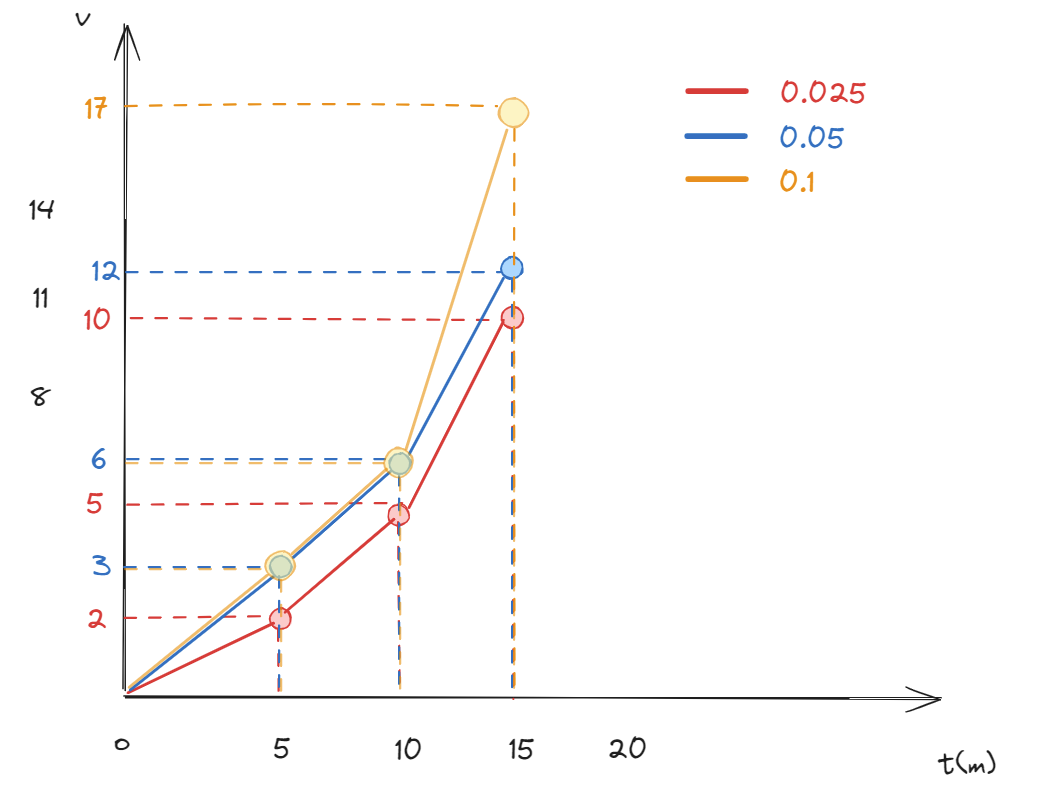

Các giá trị về số lượng phần tử được fill vào các buckets được biểu diễn theo trục Oy và sẽ tăng trưởng theo thời gian t (trục Ox)

### Phân tích biểu đồ

Xét tại 1 thời điểm t = 5 (minutes):

    - Bucket le=0.025 bao gồm 2 requests đã được fill vào
    - Bucket le=0.05 có 3 requests đã được fill vào
    - Bucket le=0.1 có 3 requests đã được fill vào
Vì vậy, Trong khoảng thời gian t = 5 số request tăng trưởng theo mỗi bucket được tăng như sau:

- Bucket range [0.025 -> 0.05] tăng: 
$\Delta$ v = 3 - 2 = 1 (có 1 request nằm trong khoảng này)
- Bucket range [0.05 -> 0.1] tăng: 
$\Delta$ v = 3 - 3 = 0 (không có request nào nằm trong khoảng này)

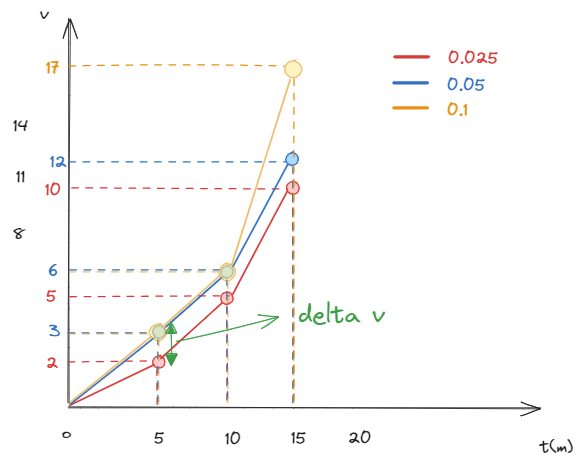
    
**Vì vậy có thể nhận thấy tại thời điểm này biến động tăng trưởng hầu hết nằm trong khoảng bucket từ [0.025 -> 0.05]**

Tương tự cách tính tìm được tại thời điểm t = 15m tăng trưởng hầu hết nằm trong khoảng bucket từ [0.05 -> 0.1]

### Xác định tăng trưởng buckets theo dòng thời gian để tính toán percentile latency

Để xét tăng trưởng của bucket theo dòng thời gian, dựa vào biểu đồ trên thì thực hiện xét điểm dữ liệu hiện tại so với điểm dữ liệu trước đó, bucket nào có độ dốc nhiều hơn thì dữ liệu biến động nhiều hơn ở bucket đó.

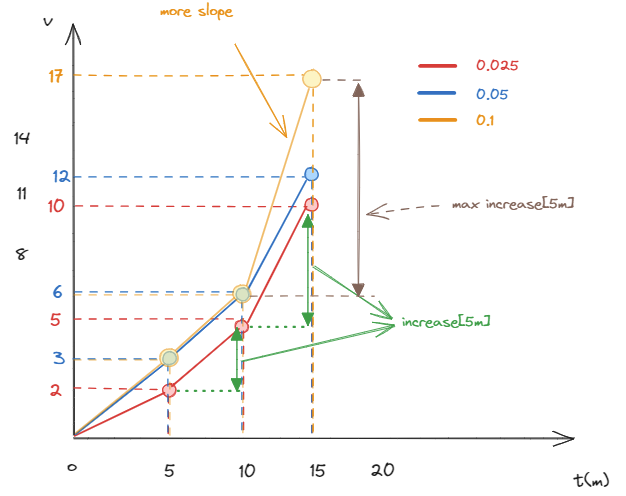

Từ biểu đồ trên có thể suy ra công thức tính tăng trưởng dữ liệu tại thời điểm  **t** sau mỗi khoảng $\Delta$ t:


**increase[t] = v[t] - v[t - $\Delta$ t]**

Đây là công thức được Prometheus sử dụng để tính giá trị tăng trưởng giữa các khoảng thời gian. Chi tiết xem tại: https://prometheus.io/docs/prometheus/latest/querying/functions/#increase

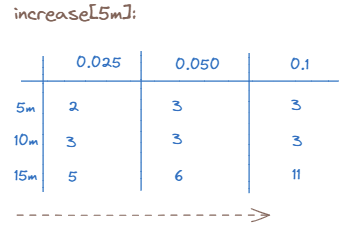

Bảng trên liệt kê kết quả tính toán tăng trưởng trên biểu đồ. Từ đây có thể dễ dàng xác định bucket range mà đa phần dữ liệu rơi vào. 
Ví dụ tại thời điểm t = 15m: 

- Bucket [0.025 -> 0.050] tăng 1
- Bucket [0.050 -> 0.1] tăng 11

-> Bucket range đa phần dữ liệu rơi vào: [0.050 -> 0.1]

Tuy nhiên, các time interval input là đa dạng (m,s,h,d) nên cần quy chuẩn giá trị tăng trưởng thành tỉ lệ tăng trưởng trong 1 khoảng thời gian T (ví dụ T = 1s).

*Công thức tính tỉ lệ tăng trưởng tại thời điểm  **t** sau mỗi khoảng $\Delta$ t:*

**rate[t] = (v[t] - v[t - $\Delta$ t]) / t**

Ví dụ: rate[5m] = (v[t] - v[t - 5m]) / (5 * 60)

Kết quả tính **rate**:

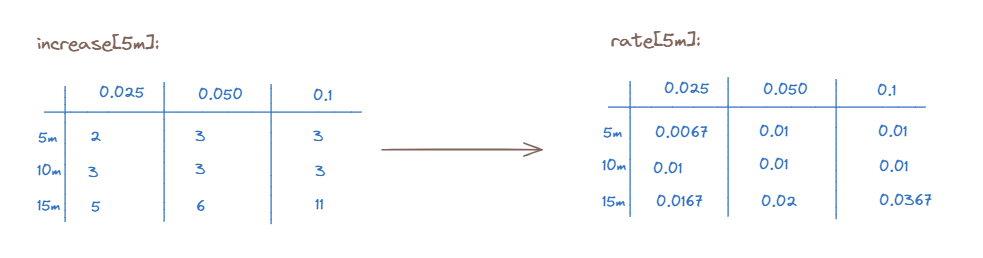

Đây là công thức Prometheus xây dựng để tính tỉ lệ trung bình tăng trưởng mỗi 1 second trong một khoảng thời gian (range vector). Từ đây có thể dễ dàng xác định bucket range mà đa phần dữ liệu rơi vào:

buckets,0.025,0.050,0.100
minutes,,,
5,0.006667,0.01,0.010000
10,0.010000,0.01,0.010000
15,0.016667,0.02,0.036667


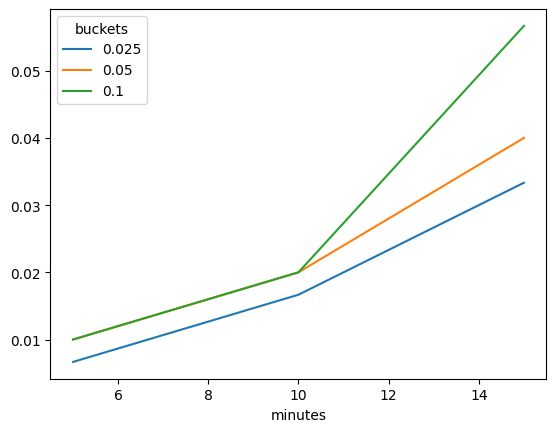

In [40]:
first_row = df.iloc[0].to_dict()
# Calculate rate[5m]
df_rate = df[[0.025, 0.050, 0.100]].diff().fillna(first_row) / (5 * 60)
df_rate.cumsum().plot()
df_rate

#### Phân tích tỉ lệ tăng trưởng buckets tại một thời điểm bất kì

Đây là thuật toán mà Prometheus sử dụng để tính toán tỉ lệ tăng trưởng tại các buckets theo dòng thời gian. Vì histogram được sử dụng trong Prometheus phân chia bucket range start từ 0 nên counter của các bucket lớn hơn sẽ bao gồm cả counter của bucket nhỏ hơn. (Buckets: 0->0.025, 0->0.05, -> 0->0.1)

*Ví dụ: Bucket **le=+Inf** sẽ bao gồm phần tử của **le=0.5 và le=0.25** hoặc bucket **le=0.5** bao gồm các phần tử của bucket **le=0.25***

**Vậy nên, khi biểu diễn các buckets trên biểu đồ thì các giá trị của bucket nhỏ hơn sẽ không bao giờ vượt quá ngưỡng giá trị của các bucket lớn hơn tại một thời điểm**

Tham khảo thêm: https://prometheus.io/docs/tutorials/understanding_metric_types/#histogram

----

Để xét tăng trưởng của bucket theo dòng thời gian, dựa vào biểu đồ trên thì thực hiện xét điểm dữ liệu hiện tại so với điểm dữ liệu trước đó, bucket nào có độ dốc nhiều hơn thì dữ liệu biến động nhiều hơn ở bucket đó.